# Import libraries

In [1]:
import os
import getpass
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import csv
import umap
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from itertools import product
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import euclidean_distances
import random
import re

2024-04-26 16:48:03.574321: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-26 16:48:03.613707: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-26 16:48:03.613741: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-26 16:48:03.614659: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-26 16:48:03.620547: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-26 16:48:03.621454: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
def extract_email(arr):
    # Check if the input is a list or array
    if isinstance(arr, list) or isinstance(arr, np.ndarray):
        # Iterate through each element
        for element in arr:
            # Recursively call the function for nested lists or arrays
            email = extract_email(element)
            if email is not None:
                return email
    # If it's a string, check if it's an email address
    elif isinstance(arr, str):
        if re.match(r"[^@]+@[^@]+\.[^@]+", arr):
            return arr
    # Return None if no email address is found
    return None

In [3]:
question_significance = {
    "seating_question_1": "Salt or Paprika?",
    "seating_question_2": "Which starter pokemon would you choose?",
    "seating_question_3": "Which Hogward house are you?",
    "seating_question_4": "Ideal friday evening?",
    "seating_question_5": "What's your favorite drink?",
    "seating_question_6": "What is most likely to exist?",
    "seating_question_7": "What is the best aroma?",
    "seating_question_8": "What where we talking about?",
    "seating_question_9": "What is your favoured language?",
    "seating_question_10": "Who do you prefer?",
}

weigths = {
    "seating_question_1": 0.5,
    "seating_question_2": 1,
    "seating_question_3": 2,
    "seating_question_4": 2,
    "seating_question_5": 6,
    "seating_question_6": 6,
    "seating_question_7": 4,
    "seating_question_8": 3,
    "seating_question_9": 5,
    "seating_question_10": 1,
}

In [4]:
# Function to update values
def update_values(value_counts):
    def update(x):
        count = value_counts.get(x)
        if count:
            return f"{x}-{count}"
        else:
            return x
    return update

In [5]:

server = "ec2-54-72-196-9.eu-west-1.compute.amazonaws.com"
db = "d2fect8juldk3k"
user = "puybkltrealynp"
pswd = getpass.getpass(prompt="Enter password: ")
pswd_to_enter = "10aefdea5dcd6a4366ab1e0f46cbf91366144b7a3ad7252478db2c63357fec4e"
# Set the PGPASSWORD environment variable
os.environ['PGPASSWORD'] = pswd

# Execute the PostgreSQL command without specifying the password
os.system(f"psql -h {server} -U {user} -d {db} -c 'SELECT name, email, name, family_name, has_answered_form, answer_friday, answer_diner, answer_ceremony, answer_reception, plusones, seating_question_1, seating_question_2, seating_question_3, seating_question_4, seating_question_5, seating_question_6, seating_question_7, seating_question_8, seating_question_9, seating_question_10, seating_question_11, seating_question_12, seating_question_13, seating_question_14, seating_question_15 FROM users;' -o seatings.csv")


Enter password:  ········


0

# Load complete database

In [6]:
full_csv = pd.read_csv(f"seatings.csv", delimiter="|")
# Strip leading and trailing spaces from every element in the DataFrame
full_csv = full_csv.applymap(lambda x: x.strip() if isinstance(x, str) else x)
full_csv.columns = full_csv.columns.str.strip()
full_csv = full_csv.dropna()

/tmp/ipykernel_177468/2183413473.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  full_csv = full_csv.applymap(lambda x: x.strip() if isinstance(x, str) else x)


In [7]:
full_csv['email'] = full_csv['email'].str.lower()
full_csv['email'] = full_csv['email'].str.rstrip('.')
full_csv.to_csv(f"seating_cleaned.csv")
full_csv

,name,email,name .1,family_name,has_answered_form,answer_friday,answer_diner,answer_ceremony,answer_reception,plusones,...,seating_question_6,seating_question_7,seating_question_8,seating_question_9,seating_question_10,seating_question_11,seating_question_12,seating_question_13,seating_question_14,seating_question_15
1,Pierre,pietdel@gmail.com,Pierre,Delacroix,yes,no,yes,no,yes,,...,06_aliens,07_pepper,08_spices,09_france,10_love_math,,,,,
2,Alexis,alexis@adbproduction.com,Alexis,,yes,no,no,no,no,,...,06_nessie,07_chocolate,08_sex,09_france,10_love_math,,,,,
3,Caroline,carolinewvh@gmail.com,Caroline,Wesselman van Helmond,yes,no,yes,no,yes,leonore.vehmeijer@gmail.com,...,06_ghost,07_chocolate,08_icecream,09_unitedkingdom,10_love_math,,,,,
4,Erica,erica.efst@gmail.com,Erica,Efstratoudakis,yes,yes,yes,yes,yes,aamoratis@gmail.com,...,06_aliens,07_chocolate,08_icecream,09_unitedkingdom,10_love_liv,,,,,
5,Darren,darrenmk1@gmail.com,Darren,Kripaitis,yes,no,yes,yes,yes,,...,06_aliens,07_pistachio,08_spices,09_unitedkingdom,10_love_math,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,Reny <3,lukitoreny@hotmail.com,Reny <3,,no,no,no,no,no,,...,,,,,,,,,,
201,Dara,khosrowshahidara@gmail.com,Dara,Khosrowshahi,yes,no,yes,no,yes,,...,06_ghost,07_pepper,08_sex,09_france,10_love_math,,,,,
202,BigNickkk,bignick@blasband.com,BigNickkk,Blasband,yes,no,yes,no,no,,...,,,,,,,,,,
203,Nikou,nikou.kh03@gmail.com,Nikou,,yes,no,yes,no,yes,,...,,,,,,,,,,


# People who answered but answered no (to double check)

In [8]:
check = full_csv[full_csv["has_answered_form"] == "yes"]
check = check[check["answer_diner"] == "no"]
check

,name,email,name .1,family_name,has_answered_form,answer_friday,answer_diner,answer_ceremony,answer_reception,plusones,...,seating_question_6,seating_question_7,seating_question_8,seating_question_9,seating_question_10,seating_question_11,seating_question_12,seating_question_13,seating_question_14,seating_question_15
2,Alexis,alexis@adbproduction.com,Alexis,,yes,no,no,no,no,,...,06_nessie,07_chocolate,08_sex,09_france,10_love_math,,,,,
19,Laureline,laureline.maheo@yahoo.fr,Laureline,,yes,no,no,no,no,,...,,,,,,,,,,
21,Clarinette,cldursel@gmail.com,Clarinette,d'Ursel,yes,no,no,no,no,,...,,,,,,,,,,
31,Kyril,kyrilwittouck@gmail.com,Kyril,,yes,no,no,no,no,,...,,,,,,,,,,
33,Valentine,vdeselliers@hotmail.com,Valentine,,yes,no,no,no,no,kyrilwittouck@gmail.com,...,,,,,,,,,,
34,Amelie,ami@dg.com,Amelie,,yes,no,no,no,no,Livia,...,06_nessie,07_pepper,08_sex,09_france,10_love_math,,,,,
36,Pauline,paulinefaucon@hotmail.com,Pauline,,yes,no,no,no,no,,...,,,,,,,,,,
43,Isaure,isauredv@gmail.com,Isaure,,yes,no,no,no,no,,...,,,,,,,,,,
46,Olivier,odeguerre@free.fr,Olivier,,yes,no,no,no,no,,...,06_nessie,07_chocolate,08_icecream,09_france,10_love_liv,,,,,
50,Sarah,sarah.cresap.johnson@gmail.com,Sarah,Clemm,yes,no,no,no,no,,...,06_nessie,07_pistachio,08_icecream,09_unitedkingdom,10_love_liv,,,,,


# Double check the plusones to include them

In [9]:
where_plus_ones = full_csv[full_csv["plusones"].str.strip() != ""][['name','email','plusones']]
where_plus_ones['plusones'] = where_plus_ones['plusones'].str.rstrip('.')
temp = pd.DataFrame()
temp['email'] = list(where_plus_ones['plusones'])
temp['who_invites_them'] = list(where_plus_ones['email'])
# Assuming df1 and df2 are your DataFrames
merged_df = pd.merge(temp, full_csv[['email','name']],on='email', how='left')
merged_df
# Filter out rows with NaN values in the columns from df2
excluded_rows = merged_df[merged_df['name'].isnull()]
excluded_rows

,email,who_invites_them,name
10,Livia,ami@dg.com,NaN
22,Louise Snoy,laurent.michiels@bain.com,NaN
27,Ania,philippe.labouchere@gmail.com,NaN
35,Thomas,valeriedeguerre@gmail.com,NaN
36,Alexandre Quarles van Ufford,odeborchgrave@gmail.com,NaN
37,Laurence de Guerre,dominique.de.guerre@orange.fr,NaN
39,Isabelle,amarschall@ab-marschall.de,NaN
40,Alexander Wynaendts,cwynaendts@gmail.com,NaN
41,ellenkrol@alzo.nl,adansembourg@freeler.nl,NaN


# Load additional information

In [10]:
additional = pd.read_csv(f"important_info.csv", delimiter=",",header=0)
additional['email'] = additional['email'].str.lower()
additional['email'] = additional['email'].str.rstrip('.')
additional

,email,Sex,friend_of,table
0,victor.stinglhamber@gmail.com,male,10_mat,1.0
1,bertichat@gmail.com,male,10_mat,1.0
2,fdelimburg@gmail.com,male,10_mat,1.0
3,jdursel@gmail.com,male,10_mat,1.0
4,harold.loop@gmail.com,male,10_mat,1.0
...,...,...,...,...
202,kyrilwittouck@gmail.com,male,10_mat,NaN
203,laureline.maheo@yahoo.fr,female,10_mat,NaN
204,paulinefaucon@hotmail.com,female,10_mat,NaN
205,vdeselliers@hotmail.com,female,10_mat,NaN


In [11]:
merged_total = pd.merge(full_csv, additional[['email','Sex', 'friend_of']], on='email', how='inner')

duplicated_indices = [6]
while len(duplicated_indices) > 0:
    try:
        duplicated_indices = merged_total[merged_total.duplicated(subset=['email'], keep=False)].index
        index_to_drop = np.random.choice(duplicated_indices)
        merged_total = merged_total.drop(index_to_drop)
    except Exception as e:
        print(e)

'a' cannot be empty unless no samples are taken


# Filter out parents

In [12]:
youth = merged_total[merged_total["friend_of"]!="10_parents"]
youth

,name,email,name .1,family_name,has_answered_form,answer_friday,answer_diner,answer_ceremony,answer_reception,plusones,...,seating_question_8,seating_question_9,seating_question_10,seating_question_11,seating_question_12,seating_question_13,seating_question_14,seating_question_15,Sex,friend_of
0,Pierre,pietdel@gmail.com,Pierre,Delacroix,yes,no,yes,no,yes,,...,08_spices,09_france,10_love_math,,,,,,male,10_mat
1,Caroline,carolinewvh@gmail.com,Caroline,Wesselman van Helmond,yes,no,yes,no,yes,leonore.vehmeijer@gmail.com,...,08_icecream,09_unitedkingdom,10_love_math,,,,,,female,10_mat
2,Erica,erica.efst@gmail.com,Erica,Efstratoudakis,yes,yes,yes,yes,yes,aamoratis@gmail.com,...,08_icecream,09_unitedkingdom,10_love_liv,,,,,,female,10_liv
3,Darren,darrenmk1@gmail.com,Darren,Kripaitis,yes,no,yes,yes,yes,,...,08_spices,09_unitedkingdom,10_love_math,,,,,,male,10_mat
4,Charles-Henri,ch.starckmann@gmail.com,Charles-Henri,Starckmann,yes,no,yes,no,yes,,...,08_icecream,09_france,10_love_liv,,,,,,male,10_mat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,Reny <3,lukitoreny@hotmail.com,Reny <3,,no,no,no,no,no,,...,,,,,,,,,female,10_mat
200,Dara,khosrowshahidara@gmail.com,Dara,Khosrowshahi,yes,no,yes,no,yes,,...,08_sex,09_france,10_love_math,,,,,,male,10_mat
201,BigNickkk,bignick@blasband.com,BigNickkk,Blasband,yes,no,yes,no,no,,...,,,,,,,,,male,10_mat
202,Nikou,nikou.kh03@gmail.com,Nikou,,yes,no,yes,no,yes,,...,,,,,,,,,female,10_mat


In [13]:
youth[['name','family_name','email','has_answered_form','answer_friday','answer_ceremony','answer_reception','answer_diner']].to_csv(f"./final_youth_db.csv")

In [14]:
parents = merged_total[merged_total["friend_of"]=="10_parents"]
parents[['name','family_name','email','has_answered_form','answer_friday','answer_ceremony','answer_reception','answer_diner']].to_csv(f"./final_parents_db.csv")

# People from who we dont have information

In [15]:
merged_df = pd.merge(full_csv[['email','name']], additional[['email']], on='email', how='outer', suffixes=('_df1', '_df2'))
# Convert lists to sets
set1 = set(list(full_csv['email']))
set2 = set(list(additional['email']))

# Find elements not shared by both sets
elements_not_shared = set1.symmetric_difference(set2)
elements_not_shared

{'alexis@adbproduction.com', 'chatelainpaul@hotmail.com', 'plusone_phillipe'}

In [16]:
emails_list = list(elements_not_shared)
# Specify the CSV file path
csv_file_path = "not_shared.csv"

# Write list to CSV file
with open(csv_file_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['email'])  # Write header
    writer.writerows([[email] for email in emails_list])

# People who answered the form but didnt do the table seating game

In [17]:
answered_invitation_but_didnt_play = youth[youth['has_answered_form'] == 'yes']
answered_invitation_but_didnt_play = answered_invitation_but_didnt_play[answered_invitation_but_didnt_play["seating_question_1"].str.strip() == ""]
answered_invitation_but_didnt_play

,name,email,name .1,family_name,has_answered_form,answer_friday,answer_diner,answer_ceremony,answer_reception,plusones,...,seating_question_8,seating_question_9,seating_question_10,seating_question_11,seating_question_12,seating_question_13,seating_question_14,seating_question_15,Sex,friend_of
17,Laureline,laureline.maheo@yahoo.fr,Laureline,,yes,no,no,no,no,,...,,,,,,,,,female,10_mat
19,Clarinette,cldursel@gmail.com,Clarinette,d'Ursel,yes,no,no,no,no,,...,,,,,,,,,female,10_mat
29,Kyril,kyrilwittouck@gmail.com,Kyril,,yes,no,no,no,no,,...,,,,,,,,,male,10_mat
31,Valentine,vdeselliers@hotmail.com,Valentine,,yes,no,no,no,no,kyrilwittouck@gmail.com,...,,,,,,,,,female,10_mat
34,Pauline,paulinefaucon@hotmail.com,Pauline,,yes,no,no,no,no,,...,,,,,,,,,female,10_mat
41,Isaure,isauredv@gmail.com,Isaure,,yes,no,no,no,no,,...,,,,,,,,,female,10_mat
65,Sunshine,alexr89@hotmail.fr,Sunshine,Renie,yes,no,yes,yes,yes,,...,,,,,,,,,male,10_mat
83,Laurent,laurent.michiels@bain.com,Laurent,Michiels,yes,no,no,no,no,Louise Snoy,...,,,,,,,,,male,10_mat
94,Julian (Jules),j.siegelmann@me.com,Julian (Jules),Siegelmann,yes,yes,yes,yes,yes,,...,,,,,,,,,male,10_liv
96,Robert,vdlindenrj@gmail.com,Robert,van der Linden,yes,no,yes,yes,yes,,...,,,,,,,,,male,10_liv


# Randomize the answers of people who didnt do the game

In [18]:
temp = youth[youth["seating_question_1"].str.strip() != ""]

all_questions = ["seating_question_1","seating_question_2","seating_question_3","seating_question_4","seating_question_5","seating_question_6","seating_question_7","seating_question_8","seating_question_9","seating_question_10"]
randomized_answers = []

for quest in all_questions:
    answers = []
    for i in range(len(answered_invitation_but_didnt_play)):
        random_element = random.choice(list(temp[quest]))
        answers.append(random_element)
    answered_invitation_but_didnt_play[quest] = answers

In [19]:
youth = pd.concat([temp, answered_invitation_but_didnt_play], axis=0)
youth

,name,email,name .1,family_name,has_answered_form,answer_friday,answer_diner,answer_ceremony,answer_reception,plusones,...,seating_question_8,seating_question_9,seating_question_10,seating_question_11,seating_question_12,seating_question_13,seating_question_14,seating_question_15,Sex,friend_of
0,Pierre,pietdel@gmail.com,Pierre,Delacroix,yes,no,yes,no,yes,,...,08_spices,09_france,10_love_math,,,,,,male,10_mat
1,Caroline,carolinewvh@gmail.com,Caroline,Wesselman van Helmond,yes,no,yes,no,yes,leonore.vehmeijer@gmail.com,...,08_icecream,09_unitedkingdom,10_love_math,,,,,,female,10_mat
2,Erica,erica.efst@gmail.com,Erica,Efstratoudakis,yes,yes,yes,yes,yes,aamoratis@gmail.com,...,08_icecream,09_unitedkingdom,10_love_liv,,,,,,female,10_liv
3,Darren,darrenmk1@gmail.com,Darren,Kripaitis,yes,no,yes,yes,yes,,...,08_spices,09_unitedkingdom,10_love_math,,,,,,male,10_mat
4,Charles-Henri,ch.starckmann@gmail.com,Charles-Henri,Starckmann,yes,no,yes,no,yes,,...,08_icecream,09_france,10_love_liv,,,,,,male,10_mat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,Phil,philippe.labouchere@gmail.com,Phil,,yes,no,no,no,no,Ania,...,08_spices,09_netherlands,10_love_math,,,,,,male,10_liv
143,Joyce,joycevn1@gmail.com,Joyce,Van Nieuwerburgh,yes,no,no,no,no,,...,08_sex,09_netherlands,10_love_math,,,,,,female,10_mat
149,Guix,guillaume.doultremont@gmail.com,Guix,d'Oultremont,yes,no,no,no,no,,...,08_icecream,09_germany,10_love_math,,,,,,male,10_mat
201,BigNickkk,bignick@blasband.com,BigNickkk,Blasband,yes,no,yes,no,no,,...,08_icecream,09_france,10_love_liv,,,,,,male,10_mat


# All people who at least started the table seating game

In [20]:
only_answered = youth[youth["seating_question_1"].str.strip() != ""]
only_answered

,name,email,name .1,family_name,has_answered_form,answer_friday,answer_diner,answer_ceremony,answer_reception,plusones,...,seating_question_8,seating_question_9,seating_question_10,seating_question_11,seating_question_12,seating_question_13,seating_question_14,seating_question_15,Sex,friend_of
0,Pierre,pietdel@gmail.com,Pierre,Delacroix,yes,no,yes,no,yes,,...,08_spices,09_france,10_love_math,,,,,,male,10_mat
1,Caroline,carolinewvh@gmail.com,Caroline,Wesselman van Helmond,yes,no,yes,no,yes,leonore.vehmeijer@gmail.com,...,08_icecream,09_unitedkingdom,10_love_math,,,,,,female,10_mat
2,Erica,erica.efst@gmail.com,Erica,Efstratoudakis,yes,yes,yes,yes,yes,aamoratis@gmail.com,...,08_icecream,09_unitedkingdom,10_love_liv,,,,,,female,10_liv
3,Darren,darrenmk1@gmail.com,Darren,Kripaitis,yes,no,yes,yes,yes,,...,08_spices,09_unitedkingdom,10_love_math,,,,,,male,10_mat
4,Charles-Henri,ch.starckmann@gmail.com,Charles-Henri,Starckmann,yes,no,yes,no,yes,,...,08_icecream,09_france,10_love_liv,,,,,,male,10_mat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,Phil,philippe.labouchere@gmail.com,Phil,,yes,no,no,no,no,Ania,...,08_spices,09_netherlands,10_love_math,,,,,,male,10_liv
143,Joyce,joycevn1@gmail.com,Joyce,Van Nieuwerburgh,yes,no,no,no,no,,...,08_sex,09_netherlands,10_love_math,,,,,,female,10_mat
149,Guix,guillaume.doultremont@gmail.com,Guix,d'Oultremont,yes,no,no,no,no,,...,08_icecream,09_germany,10_love_math,,,,,,male,10_mat
201,BigNickkk,bignick@blasband.com,BigNickkk,Blasband,yes,no,yes,no,no,,...,08_icecream,09_france,10_love_liv,,,,,,male,10_mat


# Weird group who played but answered no for dinner

In [21]:
weird_group = only_answered[only_answered["answer_diner"] == "no"]
weird_group

,name,email,name .1,family_name,has_answered_form,answer_friday,answer_diner,answer_ceremony,answer_reception,plusones,...,seating_question_8,seating_question_9,seating_question_10,seating_question_11,seating_question_12,seating_question_13,seating_question_14,seating_question_15,Sex,friend_of
32,Amelie,ami@dg.com,Amelie,,yes,no,no,no,no,Livia,...,08_sex,09_france,10_love_math,,,,,,female,10_mat
48,Sarah,sarah.cresap.johnson@gmail.com,Sarah,Clemm,yes,no,no,no,no,,...,08_icecream,09_unitedkingdom,10_love_liv,,,,,,female,10_liv
66,Tony,adenicolay@gmail.com,Tony,de Nicolay,yes,no,no,no,no,,...,08_sex,09_france,10_love_math,,,,,,male,10_mat
87,Aad,adriaanvanberckel2009@hotmail.com,Aad,,yes,no,no,no,no,,...,08_sex,,,,,,,,male,10_liv
161,Gaspar,gdursel@gmail.com,Gaspar,d'Ursel,yes,no,no,no,no,,...,08_spices,09_unitedkingdom,10_love_liv,,,,,,male,10_mat
17,Laureline,laureline.maheo@yahoo.fr,Laureline,,yes,no,no,no,no,,...,08_icecream,09_france,10_love_math,,,,,,female,10_mat
19,Clarinette,cldursel@gmail.com,Clarinette,d'Ursel,yes,no,no,no,no,,...,08_spices,09_france,10_love_liv,,,,,,female,10_mat
29,Kyril,kyrilwittouck@gmail.com,Kyril,,yes,no,no,no,no,,...,08_spices,09_unitedkingdom,10_love_math,,,,,,male,10_mat
31,Valentine,vdeselliers@hotmail.com,Valentine,,yes,no,no,no,no,kyrilwittouck@gmail.com,...,08_spices,09_unitedkingdom,10_love_math,,,,,,female,10_mat
34,Pauline,paulinefaucon@hotmail.com,Pauline,,yes,no,no,no,no,,...,08_spices,09_unitedkingdom,10_love_liv,,,,,,female,10_mat


In [22]:
len(only_answered)

155

# Filtering out those who said no to the diner

In [23]:
only_answered = only_answered[only_answered["answer_diner"]!="no"]

# Double checking one last time plusones

In [24]:
where_plus_ones = only_answered[only_answered["plusones"].str.strip() != ""][['name','email','plusones']]
where_plus_ones['plusones'] = where_plus_ones['plusones'].str.rstrip('.')
temp = pd.DataFrame()
temp['email'] = list(where_plus_ones['plusones'])
temp['who_invites_them'] = list(where_plus_ones['email'])
# Assuming df1 and df2 are your DataFrames
merged_df = pd.merge(temp, only_answered[['email','name']],on='email', how='left')
merged_df
# Filter out rows with NaN values in the columns from df2
excluded_rows = merged_df[merged_df['name'].isnull()]
excluded_rows

,email,who_invites_them,name
2,philipvb@outlook.com,mpwesterwoudt@gmail.com,NaN
9,duco@duna.io,zarahabeln@live.nl,NaN
19,laureline.maheo@yahoo.fr,charko.doultremont@gmail.com,NaN


# Only seating questions to encode

In [25]:
only_seating_colls = only_answered[["friend_of","seating_question_1","seating_question_2","seating_question_3","seating_question_4","seating_question_5","seating_question_6","seating_question_7","seating_question_8","seating_question_9","seating_question_10"]]
only_seating_colls = only_seating_colls.applymap(lambda x: str(x).split('_')[-1])
only_seating_colls.replace(r'^\s*$', "no answer", regex=True, inplace=True)
only_seating_colls

/tmp/ipykernel_177468/3761749874.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  only_seating_colls = only_seating_colls.applymap(lambda x: str(x).split('_')[-1])


,friend_of,seating_question_1,seating_question_2,seating_question_3,seating_question_4,seating_question_5,seating_question_6,seating_question_7,seating_question_8,seating_question_9,seating_question_10
0,mat,paprika,charmander,gryffondor,browncafe,wine,aliens,pepper,spices,france,math
1,mat,paprika,squirtle,huffelpuf,clubbing,tea,ghost,chocolate,icecream,unitedkingdom,math
2,liv,salt,squirtle,gryffondor,browncafe,wine,aliens,chocolate,icecream,unitedkingdom,liv
3,mat,salt,bulbasaur,huffelpuf,browncafe,beer,aliens,pistachio,spices,unitedkingdom,math
4,mat,paprika,squirtle,gryffondor,browncafe,beer,nessie,chocolate,icecream,france,liv
...,...,...,...,...,...,...,...,...,...,...,...
96,liv,paprika,charmander,ravenclaw,browncafe,wine,nessie,chocolate,sex,unitedkingdom,math
97,liv,paprika,squirtle,slitherin,browncafe,wine,nessie,chocolate,spices,unitedkingdom,liv
102,liv,paprika,charmander,gryffondor,browncafe,wine,ghost,chocolate,icecream,unitedkingdom,liv
201,mat,paprika,charmander,huffelpuf,browncafe,wine,ghost,chocolate,icecream,france,liv


In [26]:
mask = (only_seating_colls == "no answer").any(axis=1)
temp = only_answered[['name','email']]
temp = pd.concat([temp, only_seating_colls], axis = 1)
not_finished_answering = temp[mask]
not_finished_answering

,name,email,friend_of,seating_question_1,seating_question_2,seating_question_3,seating_question_4,seating_question_5,seating_question_6,seating_question_7,seating_question_8,seating_question_9,seating_question_10


In [27]:
filtered_df = only_seating_colls[~mask]
needed_later = only_answered
needed_later = needed_later[~mask]
filtered_df

,friend_of,seating_question_1,seating_question_2,seating_question_3,seating_question_4,seating_question_5,seating_question_6,seating_question_7,seating_question_8,seating_question_9,seating_question_10
0,mat,paprika,charmander,gryffondor,browncafe,wine,aliens,pepper,spices,france,math
1,mat,paprika,squirtle,huffelpuf,clubbing,tea,ghost,chocolate,icecream,unitedkingdom,math
2,liv,salt,squirtle,gryffondor,browncafe,wine,aliens,chocolate,icecream,unitedkingdom,liv
3,mat,salt,bulbasaur,huffelpuf,browncafe,beer,aliens,pistachio,spices,unitedkingdom,math
4,mat,paprika,squirtle,gryffondor,browncafe,beer,nessie,chocolate,icecream,france,liv
...,...,...,...,...,...,...,...,...,...,...,...
96,liv,paprika,charmander,ravenclaw,browncafe,wine,nessie,chocolate,sex,unitedkingdom,math
97,liv,paprika,squirtle,slitherin,browncafe,wine,nessie,chocolate,spices,unitedkingdom,liv
102,liv,paprika,charmander,gryffondor,browncafe,wine,ghost,chocolate,icecream,unitedkingdom,liv
201,mat,paprika,charmander,huffelpuf,browncafe,wine,ghost,chocolate,icecream,france,liv


In [28]:
# Initialize OneHotEncoder
encoder = OneHotEncoder()
# Fit and transform the data
encoded_data = encoder.fit_transform(filtered_df)

In [29]:
one_hot_encoded = pd.DataFrame(encoded_data.toarray(), columns = encoder.get_feature_names_out())

In [30]:
one_hot_encoded

,friend_of_liv,friend_of_mat,seating_question_1_paprika,seating_question_1_salt,seating_question_2_bulbasaur,seating_question_2_charmander,seating_question_2_squirtle,seating_question_3_gryffondor,seating_question_3_huffelpuf,seating_question_3_ravenclaw,...,seating_question_8_icecream,seating_question_8_sex,seating_question_8_spices,seating_question_9_belgium,seating_question_9_france,seating_question_9_germany,seating_question_9_netherlands,seating_question_9_unitedkingdom,seating_question_10_liv,seating_question_10_math
0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
136,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
137,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
138,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


# Weight the different questions differently

In [31]:
nr_features = {
    "friend_of": 3,
    "seating_question_1": 2,
    "seating_question_2": 3,
    "seating_question_3": 4,
    "seating_question_4": 3,
    "seating_question_5": 6,
    "seating_question_6": 5,
    "seating_question_7": 4,
    "seating_question_8": 3,
    "seating_question_9": 5,
    "seating_question_10": 2,
}

question_significance = {
    "friend_of": "Who is inviting them?",
    "seating_question_1": "Salt or Paprika?",
    "seating_question_2": "Which starter pokemon would you choose?",
    "seating_question_3": "Which Hogward house are you?",
    "seating_question_4": "Ideal friday evening?",
    "seating_question_5": "What's your favorite drink?",
    "seating_question_6": "What is most likely to exist?",
    "seating_question_7": "What is the best aroma?",
    "seating_question_8": "What where we talking about?",
    "seating_question_9": "What is your favoured language?",
    "seating_question_10": "Who do you prefer?",
}


weigths = {
    "friend_of": 0,
    "seating_question_1": 0.4,
    "seating_question_2": 1.2,
    "seating_question_3": 0.9,
    "seating_question_4": 0.7,
    "seating_question_5": 0.6,
    "seating_question_6": 0.8,
    "seating_question_7": 0.5,
    "seating_question_8": 0.5,
    "seating_question_9": 0.5,
    "seating_question_10": 0.5,
}

In [32]:
scaler = StandardScaler()
scaler.fit(one_hot_encoded)
normalized_data = scaler.transform(one_hot_encoded)
one_hot_encoded = pd.DataFrame(normalized_data, columns=one_hot_encoded.columns)
temp = list(one_hot_encoded.columns)
modified_array = [word[:word.rindex('_')] for word in temp]
to_multi_1 = []
to_multi_2 = []
for word in modified_array:
    to_multi_1.append(weigths[word])
    to_multi_2.append(nr_features[word])
# Multiply each column with its corresponding float
for i, col in enumerate(one_hot_encoded.columns):
    one_hot_encoded[col] = one_hot_encoded[col] * to_multi_1[i]
    one_hot_encoded[col] = one_hot_encoded[col] * to_multi_2[i]
one_hot_encoded

,friend_of_liv,friend_of_mat,seating_question_1_paprika,seating_question_1_salt,seating_question_2_bulbasaur,seating_question_2_charmander,seating_question_2_squirtle,seating_question_3_gryffondor,seating_question_3_huffelpuf,seating_question_3_ravenclaw,...,seating_question_8_icecream,seating_question_8_sex,seating_question_8_spices,seating_question_9_belgium,seating_question_9_france,seating_question_9_germany,seating_question_9_netherlands,seating_question_9_unitedkingdom,seating_question_10_liv,seating_question_10_math
0,-0.0,0.0,0.73413,-0.73413,-2.038868,3.704369,-2.197325,4.156922,-1.719241,-1.554436,...,-1.5,-0.816497,2.457534,-0.212047,2.845042,-0.693375,-0.990659,-1.834498,-1.281214,1.281214
1,-0.0,0.0,0.73413,-0.73413,-2.038868,-3.498571,5.898082,-3.117691,7.538210,-1.554436,...,1.5,-0.816497,-0.915552,-0.212047,-2.196804,-0.693375,-0.990659,3.406926,-1.281214,1.281214
2,0.0,-0.0,-0.87178,0.87178,-2.038868,-3.498571,5.898082,4.156922,-1.719241,-1.554436,...,1.5,-0.816497,-0.915552,-0.212047,-2.196804,-0.693375,-0.990659,3.406926,0.780510,-0.780510
3,-0.0,0.0,-0.87178,0.87178,6.356470,-3.498571,-2.197325,-3.117691,7.538210,-1.554436,...,-1.5,-0.816497,2.457534,-0.212047,-2.196804,-0.693375,-0.990659,3.406926,-1.281214,1.281214
4,-0.0,0.0,0.73413,-0.73413,-2.038868,-3.498571,5.898082,4.156922,-1.719241,-1.554436,...,1.5,-0.816497,-0.915552,-0.212047,2.845042,-0.693375,-0.990659,-1.834498,0.780510,-0.780510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,0.0,-0.0,0.73413,-0.73413,-2.038868,3.704369,-2.197325,-3.117691,-1.719241,8.337429,...,-1.5,2.755676,-0.915552,-0.212047,-2.196804,-0.693375,-0.990659,3.406926,-1.281214,1.281214
136,0.0,-0.0,0.73413,-0.73413,-2.038868,-3.498571,5.898082,-3.117691,-1.719241,-1.554436,...,-1.5,-0.816497,2.457534,-0.212047,-2.196804,-0.693375,-0.990659,3.406926,0.780510,-0.780510
137,0.0,-0.0,0.73413,-0.73413,-2.038868,3.704369,-2.197325,4.156922,-1.719241,-1.554436,...,1.5,-0.816497,-0.915552,-0.212047,-2.196804,-0.693375,-0.990659,3.406926,0.780510,-0.780510
138,-0.0,0.0,0.73413,-0.73413,-2.038868,3.704369,-2.197325,-3.117691,7.538210,-1.554436,...,1.5,-0.816497,-0.915552,-0.212047,2.845042,-0.693375,-0.990659,-1.834498,0.780510,-0.780510


# Run PCA

In [33]:
nr_lower_dims = 2
lower_dims_labels = [f"dim{i}" for i in range(1, nr_lower_dims + 1)]

In [34]:
pca = PCA(n_components=nr_lower_dims)

# Fit the PCA model to your one-hot encoded DataFrame
pca.fit(one_hot_encoded)

# Transform the data to its principal components
pca_result = pca.transform(one_hot_encoded)

# Create a new DataFrame to store the principal components
pca_df = pd.DataFrame(data=pca_result, columns=lower_dims_labels)

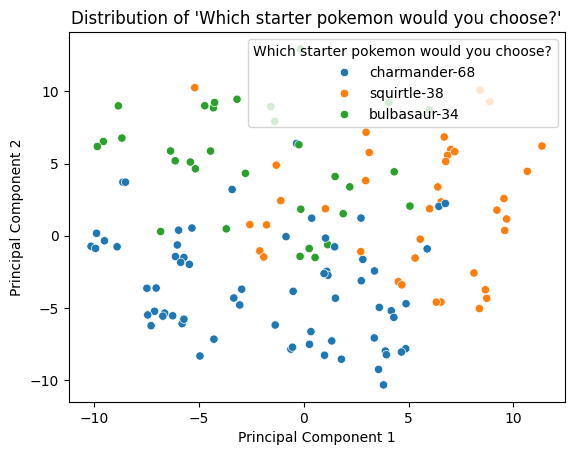

In [35]:
current_question = "seating_question_2"
signify = question_significance[current_question]
pca_df[signify] = list(filtered_df[current_question])
value_counts = pca_df[signify].value_counts()
pca_df[signify] = pca_df[signify].apply(update_values(value_counts))
# Create a scatter plot using Seaborn
sns.scatterplot(x='dim1', y='dim2', data=pca_df, hue = signify)
plt.title(f"Distribution of '{signify}'")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Run UMAP

In [36]:
# Run UMAP
reducer = umap.UMAP(n_components=nr_lower_dims)
embedding = reducer.fit_transform(one_hot_encoded)

In [37]:
# Create a new DataFrame to store the principal components
umap_df = pd.DataFrame(data=embedding, columns=lower_dims_labels)

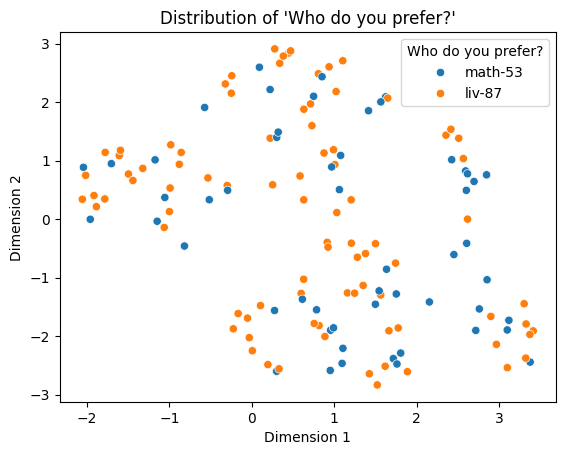

In [38]:
current_question = "seating_question_10"
signify = question_significance[current_question]
umap_df[signify] = list(filtered_df[current_question])
value_counts = umap_df[signify].value_counts()
umap_df[signify] = umap_df[signify].apply(update_values(value_counts))
# Create a scatter plot using Seaborn
sns.scatterplot(x='dim1', y='dim2', data=umap_df, hue = signify)
plt.title(f"Distribution of '{signify}'")
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

# Cluster pairs

In [39]:
nr_lower_dim = nr_lower_dims # based on how many dims you calculate the distance
lower_dims_labels = [f"dim{i}" for i in range(1, nr_lower_dims + 1)]

In [40]:
#chosen_dim = umap_df[lower_dims_labels] # choose umap or PCA (or others)
chosen_dim = umap_df[lower_dims_labels] # choose umap or PCA (or others)
chosen_dim['gender'] = list(needed_later['Sex'])
chosen_dim['email'] = list(needed_later['email'])

In [41]:
gender_counts = chosen_dim['gender'].value_counts()
if gender_counts.female >= gender_counts.male:
    most_present = "female"
else:
    most_present = "male"

In [42]:
gender_counts.female

72

In [43]:
gender_counts.male

68

In [44]:
most_present

'female'

In [45]:
table_names_and_sizes = {
    "goldstrike":[32],
    "tequila":[14],
    "jagermeister":[14],
    "liquer43":[14],
    "salmari":[12],
    "limoncello":[12],
    "cointreau":[10],
    "peardrop":[9],
    "curacao":[12],
    "genepi":[10],
}

nr_of_tables = len(table_names_and_sizes)

In [46]:
if most_present == 'female':
    least_present = 'male'
    starting_df = chosen_dim[chosen_dim['gender']=='male'][lower_dims_labels+['email']]
    overschot = chosen_dim[chosen_dim['gender']=='female'][lower_dims_labels+['email']]
else:
    least_present = 'female'
    overschot = chosen_dim[chosen_dim['gender']=='male'][lower_dims_labels+['email']]
    starting_df = chosen_dim[chosen_dim['gender']=='female'][lower_dims_labels+['email']]

In [47]:
extraction = one_hot_encoded.copy()
extraction['email'] = list(needed_later['email'])
extraction['name'] = list(needed_later['name'])
extraction['family_name'] = list(needed_later['family_name'])
columns = extraction.columns.tolist()
new_columns = columns[-3:] + columns[:-3]
extraction = extraction[new_columns]

matching_pairs_one_hot = []
matching_pairs_emails = []

nn = NearestNeighbors(n_neighbors=1, algorithm='auto')
starting_df = starting_df.sample(frac=1).reset_index(drop=True)

while len(starting_df) > 0:
    df1 = starting_df.head(1)
    df2 = overschot
    # Convert pandas DataFrames to numpy arrays
    df1_array = df1[lower_dims_labels].to_numpy()
    df2_array = df2[lower_dims_labels].to_numpy()
    df2_to_read = df2.to_numpy()

    # Flatten the arrays to 2D
    df1_flat = df1_array.reshape(len(df1_array), -1)
    df2_flat = df2_array.reshape(len(df2_array), -1)
    df2_to_read_flat = df2_to_read.reshape(len(df2_to_read), -1)

    nn.fit(df2_flat)
    distances, indices = nn.kneighbors(df1_flat)

    email_overschot = extract_email(df2_to_read_flat[indices])
    email_init = list(df1.email)[0]

    starting_df = starting_df[starting_df['email'] != email_init]
    overschot = overschot[overschot['email'] != email_overschot]

    couple = extraction[(extraction['email'] == email_overschot) | (extraction['email'] == email_init)]
    couple_additional_info = chosen_dim[(chosen_dim['email'] == email_overschot) | (chosen_dim['email'] == email_init)]
    merged_df = pd.merge(couple_additional_info, couple, on='email')
    columns = merged_df.columns.tolist()
    new_columns = merged_df.columns[3:6].tolist() + [col for col in columns if col not in merged_df.columns[3:6]]
    couple = merged_df[new_columns]

    matching_pairs_one_hot.append(couple)
    matching_pairs_emails.append([email_init,email_overschot])

In [48]:
matching_pairs_emails_df = pd.DataFrame(matching_pairs_emails, columns = [f"email {least_present}",f"email {most_present}"])
matching_pairs_emails_df

,email male,email female
0,stevenvriesendorp@hotmail.com,camilledansembourg@gmail.com
1,adelin.philippe@gmail.com,l.h.devries@outlook.com
2,jdursel@gmail.com,mvlvputbus@gmail.com
3,marsanraphael@gmail.com,alice.athanassiadis@gmail.com
4,matthieu.dehemptinne@gmail.com,liviadeguerre@gmail.com
...,...,...
63,bertichat@gmail.com,popowskixenia@gmail.com
64,cvdboogaard@msn.com,louisedehaas@hotmail.com
65,arnaud.decleve0807@gmail.com,maddejamb@gmail.com
66,ch.starckmann@gmail.com,jiuliadansembourg@gmail.com


# Re-run for overschot

In [49]:
if most_present == 'female':
    least_present = 'male'
    starting_df = overschot
    overschot = chosen_dim[chosen_dim['gender']=='male'][lower_dims_labels+['email']]
else:
    least_present = 'female'
    starting_df = overschot
    overschot = chosen_dim[chosen_dim['gender']=='female'][lower_dims_labels+['email']]

In [50]:
matching_pairs_overschot_one_hot = []
matching_pairs_overschot_emails = []
starting_df = starting_df.sample(frac=1).reset_index(drop=True)
while len(starting_df) > 0:
    df1 = starting_df.head(1)
    df2 = overschot
    # Convert pandas DataFrames to numpy arrays
    df1_array = df1[lower_dims_labels].to_numpy()
    df2_array = df2[lower_dims_labels].to_numpy()
    df2_to_read = df2.to_numpy()

    # Flatten the arrays to 2D
    df1_flat = df1_array.reshape(len(df1_array), -1)
    df2_flat = df2_array.reshape(len(df2_array), -1)
    df2_to_read_flat = df2_to_read.reshape(len(df2_to_read), -1)

    nn.fit(df2_flat)
    distances, indices = nn.kneighbors(df1_flat)

    email_overschot = extract_email(df2_to_read_flat[indices])
    email_init = list(df1.email)[0]

    starting_df = starting_df[starting_df['email'] != email_init]
    overschot = overschot[overschot['email'] != email_overschot]

    couple = extraction[(extraction['email'] == email_overschot) | (extraction['email'] == email_init)]
    couple_additional_info = chosen_dim[(chosen_dim['email'] == email_overschot) | (chosen_dim['email'] == email_init)]
    merged_df = pd.merge(couple_additional_info, couple, on='email')
    columns = merged_df.columns.tolist()
    new_columns = merged_df.columns[3:6].tolist() + [col for col in columns if col not in merged_df.columns[3:6]]
    couple = merged_df[new_columns]

    matching_pairs_overschot_one_hot.append(couple)
    matching_pairs_overschot_emails.append([email_init,email_overschot])

In [51]:
matching_pairs_overschot_emails_df = pd.DataFrame(matching_pairs_overschot_emails, columns = [f"email {most_present} overschot",f"email {least_present}"])
matching_pairs_overschot_emails_df

,email female overschot,email male
0,ohman.molly@gmail.com,ch.starckmann@gmail.com
1,cathelijnevanderwouden@gmail.com,jdursel@gmail.com
2,leonore.vehmeijer@gmail.com,fdelimburg@gmail.com
3,marie.vdhoeven@gmail.com,leopold.gerard@gmail.com


In [52]:
similarity_groups = pd.merge(matching_pairs_emails_df, matching_pairs_overschot_emails_df, on=f"email {least_present}", how="outer")
similarity_groups

,email male,email female,email female overschot
0,stevenvriesendorp@hotmail.com,camilledansembourg@gmail.com,NaN
1,adelin.philippe@gmail.com,l.h.devries@outlook.com,NaN
2,jdursel@gmail.com,mvlvputbus@gmail.com,cathelijnevanderwouden@gmail.com
3,marsanraphael@gmail.com,alice.athanassiadis@gmail.com,NaN
4,matthieu.dehemptinne@gmail.com,liviadeguerre@gmail.com,NaN
...,...,...,...
63,bertichat@gmail.com,popowskixenia@gmail.com,NaN
64,cvdboogaard@msn.com,louisedehaas@hotmail.com,NaN
65,arnaud.decleve0807@gmail.com,maddejamb@gmail.com,NaN
66,ch.starckmann@gmail.com,jiuliadansembourg@gmail.com,ohman.molly@gmail.com


# Recompressing for anti-pairs

In [53]:
extraction

,email,name,family_name,friend_of_liv,friend_of_mat,seating_question_1_paprika,seating_question_1_salt,seating_question_2_bulbasaur,seating_question_2_charmander,seating_question_2_squirtle,...,seating_question_8_icecream,seating_question_8_sex,seating_question_8_spices,seating_question_9_belgium,seating_question_9_france,seating_question_9_germany,seating_question_9_netherlands,seating_question_9_unitedkingdom,seating_question_10_liv,seating_question_10_math
0,pietdel@gmail.com,Pierre,Delacroix,-0.0,0.0,0.73413,-0.73413,-2.038868,3.704369,-2.197325,...,-1.5,-0.816497,2.457534,-0.212047,2.845042,-0.693375,-0.990659,-1.834498,-1.281214,1.281214
1,carolinewvh@gmail.com,Caroline,Wesselman van Helmond,-0.0,0.0,0.73413,-0.73413,-2.038868,-3.498571,5.898082,...,1.5,-0.816497,-0.915552,-0.212047,-2.196804,-0.693375,-0.990659,3.406926,-1.281214,1.281214
2,erica.efst@gmail.com,Erica,Efstratoudakis,0.0,-0.0,-0.87178,0.87178,-2.038868,-3.498571,5.898082,...,1.5,-0.816497,-0.915552,-0.212047,-2.196804,-0.693375,-0.990659,3.406926,0.780510,-0.780510
3,darrenmk1@gmail.com,Darren,Kripaitis,-0.0,0.0,-0.87178,0.87178,6.356470,-3.498571,-2.197325,...,-1.5,-0.816497,2.457534,-0.212047,-2.196804,-0.693375,-0.990659,3.406926,-1.281214,1.281214
4,ch.starckmann@gmail.com,Charles-Henri,Starckmann,-0.0,0.0,0.73413,-0.73413,-2.038868,-3.498571,5.898082,...,1.5,-0.816497,-0.915552,-0.212047,2.845042,-0.693375,-0.990659,-1.834498,0.780510,-0.780510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,vdlindenrj@gmail.com,Robert,van der Linden,0.0,-0.0,0.73413,-0.73413,-2.038868,3.704369,-2.197325,...,-1.5,2.755676,-0.915552,-0.212047,-2.196804,-0.693375,-0.990659,3.406926,-1.281214,1.281214
136,gj.oudewesselink@gmail.com,Gizz,,0.0,-0.0,0.73413,-0.73413,-2.038868,-3.498571,5.898082,...,-1.5,-0.816497,2.457534,-0.212047,-2.196804,-0.693375,-0.990659,3.406926,0.780510,-0.780510
137,popowskixenia@gmail.com,Xenia,,0.0,-0.0,0.73413,-0.73413,-2.038868,3.704369,-2.197325,...,1.5,-0.816497,-0.915552,-0.212047,-2.196804,-0.693375,-0.990659,3.406926,0.780510,-0.780510
138,bignick@blasband.com,BigNickkk,Blasband,-0.0,0.0,0.73413,-0.73413,-2.038868,3.704369,-2.197325,...,1.5,-0.816497,-0.915552,-0.212047,2.845042,-0.693375,-0.990659,-1.834498,0.780510,-0.780510


In [54]:
similarity_groups

,email male,email female,email female overschot
0,stevenvriesendorp@hotmail.com,camilledansembourg@gmail.com,NaN
1,adelin.philippe@gmail.com,l.h.devries@outlook.com,NaN
2,jdursel@gmail.com,mvlvputbus@gmail.com,cathelijnevanderwouden@gmail.com
3,marsanraphael@gmail.com,alice.athanassiadis@gmail.com,NaN
4,matthieu.dehemptinne@gmail.com,liviadeguerre@gmail.com,NaN
...,...,...,...
63,bertichat@gmail.com,popowskixenia@gmail.com,NaN
64,cvdboogaard@msn.com,louisedehaas@hotmail.com,NaN
65,arnaud.decleve0807@gmail.com,maddejamb@gmail.com,NaN
66,ch.starckmann@gmail.com,jiuliadansembourg@gmail.com,ohman.molly@gmail.com


In [55]:
col_male = [name + "_male" for name in extraction.columns[3:]]
col_female = [name + "_female" for name in extraction.columns[3:]]
combined_headers = col_male + col_female

In [56]:
combined_arrays = []
for index, row in similarity_groups.iterrows():
    # Access row data using row['column_name'] or row[column_index]
    exctract_male = extraction[extraction['email'] == row[f"email {least_present}"]]
    exctract_female = extraction[extraction['email'] == row[f"email {most_present}"]]
    exctract_male_values = exctract_male.iloc[0].values[3:]
    exctract_female_values = exctract_female.iloc[0].values[3:]
    combined_values = list(exctract_male_values) + list(exctract_female_values)
    combined_arrays.append(combined_values)

In [57]:
lovers = pd.DataFrame(combined_arrays, columns = combined_headers)
lovers

,friend_of_liv_male,friend_of_mat_male,seating_question_1_paprika_male,seating_question_1_salt_male,seating_question_2_bulbasaur_male,seating_question_2_charmander_male,seating_question_2_squirtle_male,seating_question_3_gryffondor_male,seating_question_3_huffelpuf_male,seating_question_3_ravenclaw_male,...,seating_question_8_icecream_female,seating_question_8_sex_female,seating_question_8_spices_female,seating_question_9_belgium_female,seating_question_9_france_female,seating_question_9_germany_female,seating_question_9_netherlands_female,seating_question_9_unitedkingdom_female,seating_question_10_liv_female,seating_question_10_math_female
0,0.0,-0.0,-0.87178,0.87178,-2.038868,3.704369,-2.197325,4.156922,-1.719241,-1.554436,...,-1.5,2.755676,-0.915552,-0.212047,-2.196804,9.013878,-0.990659,-1.834498,0.780510,-0.780510
1,-0.0,0.0,0.73413,-0.73413,-2.038868,3.704369,-2.197325,4.156922,-1.719241,-1.554436,...,1.5,-0.816497,-0.915552,-0.212047,-2.196804,-0.693375,6.308933,-1.834498,0.780510,-0.780510
2,-0.0,0.0,0.73413,-0.73413,-2.038868,-3.498571,5.898082,-3.117691,-1.719241,-1.554436,...,-1.5,-0.816497,2.457534,-0.212047,2.845042,-0.693375,-0.990659,-1.834498,-1.281214,1.281214
3,-0.0,0.0,-0.87178,0.87178,-2.038868,-3.498571,5.898082,-3.117691,-1.719241,-1.554436,...,1.5,-0.816497,-0.915552,-0.212047,2.845042,-0.693375,-0.990659,-1.834498,-1.281214,1.281214
4,-0.0,0.0,0.73413,-0.73413,6.356470,-3.498571,-2.197325,-3.117691,-1.719241,8.337429,...,-1.5,2.755676,-0.915552,-0.212047,-2.196804,-0.693375,-0.990659,3.406926,0.780510,-0.780510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,-0.0,0.0,0.73413,-0.73413,-2.038868,3.704369,-2.197325,-3.117691,7.538210,-1.554436,...,1.5,-0.816497,-0.915552,-0.212047,-2.196804,-0.693375,-0.990659,3.406926,0.780510,-0.780510
64,0.0,-0.0,-0.87178,0.87178,-2.038868,3.704369,-2.197325,-3.117691,-1.719241,-1.554436,...,1.5,-0.816497,-0.915552,-0.212047,-2.196804,-0.693375,6.308933,-1.834498,0.780510,-0.780510
65,0.0,-0.0,-0.87178,0.87178,6.356470,-3.498571,-2.197325,-3.117691,-1.719241,-1.554436,...,-1.5,-0.816497,2.457534,-0.212047,2.845042,-0.693375,-0.990659,-1.834498,-1.281214,1.281214
66,-0.0,0.0,0.73413,-0.73413,-2.038868,-3.498571,5.898082,4.156922,-1.719241,-1.554436,...,1.5,-0.816497,-0.915552,-0.212047,2.845042,-0.693375,-0.990659,-1.834498,-1.281214,1.281214


# ReRun PCA

In [58]:
nr_lower_dims = 2
lower_dims_labels = [f"dim{i}" for i in range(1, nr_lower_dims + 1)]
pca = PCA(n_components=nr_lower_dims)

# Fit the PCA model to your one-hot encoded DataFrame
pca.fit(lovers)

# Transform the data to its principal components
pca_result = pca.transform(lovers)

# Create a new DataFrame to store the principal components
pca_df = pd.DataFrame(data=pca_result, columns=lower_dims_labels)

# ReRun UMAP

In [59]:
# Run UMAP
reducer = umap.UMAP(n_components=nr_lower_dims)
embedding = reducer.fit_transform(lovers)
# Create a new DataFrame to store the principal components
umap_df = pd.DataFrame(data=embedding, columns=lower_dims_labels)

# Create Nemesis clusters

In [60]:
nr_lower_dim = nr_lower_dims # based on how many dims you calculate the distance
lower_dims_labels = [f"dim{i}" for i in range(1, nr_lower_dims + 1)]

In [61]:
#chosen_dim = umap_df[lower_dims_labels] # choose umap or PCA (or others)
chosen_dim = umap_df[lower_dims_labels] # choose umap or PCA (or others)

In [62]:
similarity_groups

,email male,email female,email female overschot
0,stevenvriesendorp@hotmail.com,camilledansembourg@gmail.com,NaN
1,adelin.philippe@gmail.com,l.h.devries@outlook.com,NaN
2,jdursel@gmail.com,mvlvputbus@gmail.com,cathelijnevanderwouden@gmail.com
3,marsanraphael@gmail.com,alice.athanassiadis@gmail.com,NaN
4,matthieu.dehemptinne@gmail.com,liviadeguerre@gmail.com,NaN
...,...,...,...
63,bertichat@gmail.com,popowskixenia@gmail.com,NaN
64,cvdboogaard@msn.com,louisedehaas@hotmail.com,NaN
65,arnaud.decleve0807@gmail.com,maddejamb@gmail.com,NaN
66,ch.starckmann@gmail.com,jiuliadansembourg@gmail.com,ohman.molly@gmail.com


In [63]:
most_present

'female'

In [80]:
chosen_dim[f"email {least_present}"] = list(similarity_groups[f"email {least_present}"])
chosen_dim[f"email {most_present}"] = list(similarity_groups[f"email {most_present}"])
chosen_dim[f"email {most_present} overschot"] = list(similarity_groups[f"email {most_present} overschot"])

In [81]:
starting_df = chosen_dim.copy()
nemesises = []
while len(starting_df) > 0:
    try:
        starting_df = starting_df.sample(frac=1).reset_index(drop=True)

        # Check if DataFrame is not empty after shuffling
        if len(starting_df) == 0:
            break
        
        good = [starting_df.iloc[0][f"email {least_present}"],
                starting_df.iloc[0][f"email {most_present}"],
                starting_df.iloc[0][f"email {most_present} overschot"]]
        data = starting_df[lower_dims_labels].values
        distances = euclidean_distances(data, [data[0]])
        index_max_distance = distances.argmax()
        bad = [starting_df.iloc[index_max_distance][f"email {least_present}"],
               starting_df.iloc[index_max_distance][f"email {most_present}"],
                starting_df.iloc[index_max_distance][f"email {most_present} overschot"]]
        
        
        starting_df = starting_df[starting_df[f"email {least_present}"] != good[0]]
        starting_df = starting_df[starting_df[f"email {least_present}"] != bad[0]]
        nemesises.append(good + bad)
    except Exception as e:
        print(e)
        overschot_nemesis = starting_df.copy()

In [82]:
cols = [f"{least_present} good", f"{most_present} good", f"{most_present} overschot good", f"{least_present} bad", f"{most_present} bad", f"{most_present} overschot bad"]

In [83]:
nemesises = pd.DataFrame(data = nemesises, columns = cols)
nemesises

,male good,female good,female overschot good,male bad,female bad,female overschot bad
0,geoffroydecanniere@gmail.com,ipn@vub.de,NaN,h.p.wynaendts@gmail.com,hortensevincotte@gmail.com,NaN
1,eberhard@redrink.co,sophiedelacroix@hotmail.com,NaN,sammie.katt@gmail.com,alice.j.sommer@gmail.com,NaN
2,adelin.philippe@gmail.com,l.h.devries@outlook.com,NaN,alexsvo@me.com,zarahabeln@live.nl,NaN
3,matthijsdekempenaer@gmail.com,sophiewynaendts@gmail.com,NaN,n.wery@outlook.com,ilse.m.schol@gmail.com,NaN
4,pietdel@gmail.com,mariettebalder@gmail.com,NaN,harold.delacroix@gmail.com,paulineranscelot@gmail.com,NaN
5,thomasdeguerre@gmail.com,vandenbulcke.cha@gmail.com,NaN,maxime@paternotte.com,leaverdoodt@gmail.com,NaN
6,edzard.knyphausen@gmail.com,amelboes@hotmail.com,NaN,sam.rz@hotmail.com,a.k.greul@gmail.com,NaN
7,khosrowshahidara@gmail.com,n.z.borren@gmail.com,NaN,jeroenvandishoeck@hotmail.com,lotti.von.quadt@student.uva.nl,NaN
8,bertichat@gmail.com,popowskixenia@gmail.com,NaN,thomvincotte@hotmail.com,emily.vanwassenhove@gmail.com,NaN
9,maartenjr.esser@gmail.com,marie.osterrieth@gmail.com,NaN,maurice.vanmanen@hotmail.com,resitherwood@gmail.com,NaN


In [93]:
# Define the cluster sizes
cluster_sizes = [12, 15, 32, 6, 21]

# Initialize KMeans with the desired number of clusters
kmeans = KMeans(n_clusters=len(cluster_sizes))

# Fit KMeans to the UMAP-transformed data
clusters = kmeans.fit_predict(embedding)

# Assign each data point to a cluster
cluster_assignments = []
start = 0
for size in cluster_sizes:
    end = start + size
    cluster_assignments.append(clusters[start:end])
    start = end


/home/mat2m10/miniconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [94]:
# Extract cluster labels
cluster_labels = kmeans.labels_
cluster_labels

array([2, 1, 2, 4, 1, 1, 4, 1, 0, 4, 3, 3, 1, 0, 4, 1, 0, 1, 4, 2, 2, 3,
       0, 1, 0, 3, 1, 1, 0, 4, 4, 4, 0, 2, 3, 2, 0, 4, 4, 4, 1, 4, 3, 1,
       0, 2, 4, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 3, 2, 4, 2, 3, 3, 2, 3, 0,
       2, 4, 1, 4, 3, 3, 2, 0, 4, 2, 4, 2, 4, 2, 2, 1, 2, 2, 0, 4, 3, 2,
       2, 1, 4, 0, 4, 1, 0, 2, 2, 2, 1, 2], dtype=int32)

In [95]:
umap_df['tabels'] = cluster_labels

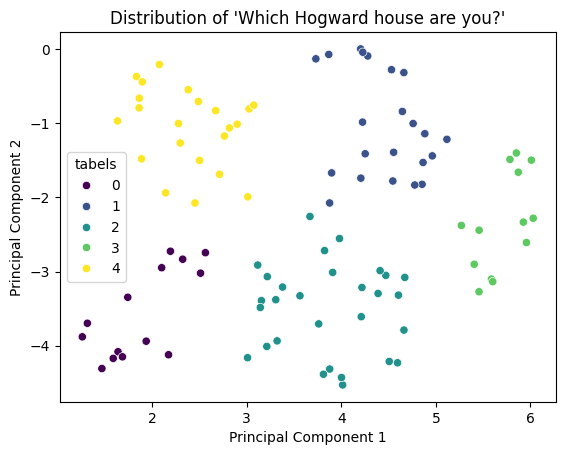

In [96]:
sns.scatterplot(x='dim1', y='dim2', data=umap_df, hue = 'tabels',palette = 'viridis')
plt.title(f"Distribution of '{signify}'")
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Groups of males and females

In [99]:
umap_df = umap_df[['dim1','dim2','tabels']]
umap_df['gender'] = list(needed_later['Sex'])
umap_df['email'] = list(needed_later['email'])

In [100]:
# Assuming umap_df is your DataFrame with columns 'dim1', 'dim2', and 'gender'
male_df = umap_df[umap_df['gender'] == 'male']
female_df = umap_df[umap_df['gender'] == 'female']

# Compute pairwise distances between male and female samples
distances = cdist(male_df[['dim1', 'dim2']], female_df[['dim1', 'dim2']])

# Find the closest male-female pairs
min_indices = distances.argmin(axis=1)
closest_pairs = [(male_df.iloc[i], female_df.iloc[j]) for i, j in enumerate(min_indices)]

# Create a DataFrame with the closest pairs
closest_pairs_df = pd.DataFrame(closest_pairs, columns=['Male', 'Female'])


In [148]:
pair = closest_pairs_df.iloc[0]
male = pair['Male']
female = pair['Female']
match = pd.concat([pd.DataFrame(data=male),pd.DataFrame(data=female)],axis=1)
first_db = needed_later[['email','name','family_name']]
first_merge = pd.merge(first_db, match.T[['dim1','dim2','email']], on='email', how='inner')
values_array = [value for value in question_significance.values()]
third_db = needed_later[["friend_of","seating_question_1","seating_question_2","seating_question_3","seating_question_4","seating_question_5","seating_question_6","seating_question_7","seating_question_8","seating_question_9","seating_question_10"]]
# Create a dictionary mapping old column names to new column names
column_mapping = dict(zip(third_db.columns, values_array))

# Rename columns using the dictionary
third_db.rename(columns=column_mapping, inplace=True)
third_db = third_db.applymap(lambda x: str(x).split('_')[-1])
third_db.replace(r'^\s*$', "no answer", regex=True, inplace=True)
third_db['email'] = list(needed_later['email'])
last_merge = pd.merge(first_merge, third_db, on='email', how='inner')
last_merge

/tmp/ipykernel_34378/4076693006.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  third_db.rename(columns=column_mapping, inplace=True)
/tmp/ipykernel_34378/4076693006.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  third_db = third_db.applymap(lambda x: str(x).split('_')[-1])


,email,name,family_name,dim1,dim2,Who is inviting them?,Salt or Paprika?,Which starter pokemon would you choose?,Which Hogward house are you?,Ideal friday evening?,What's your favorite drink?,What is most likely to exist?,What is the best aroma?,What where we talking about?,What is your favoured language?,Who do you prefer?
0,pietdel@gmail.com,Pierre,Delacroix,3.562992,-3.326744,mat,paprika,charmander,gryffondor,browncafe,wine,aliens,pepper,spices,france,math
1,poli.camilla@gmail.com,Camilla,Poli,3.379089,-3.209302,mat,salt,charmander,gryffondor,browncafe,wine,aliens,chocolate,spices,unitedkingdom,math
